In [1]:
import os
import h5py
import numpy as np
import scipy.signal as signal
from scipy.signal import butter, filtfilt, detrend, hilbert, decimate, stft
from scipy.signal.windows import tukey
from matplotlib.colors import LogNorm
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pyproj import Proj

from scipy.fft import fft2, fftfreq, fftshift, ifft2, ifftshift
from scipy.ndimage import gaussian_filter

In [2]:
def fk_filt(data,tint,fs,xint,dx,c_min,c_max):
    data_fft = fft2(detrend(data))
    # Make freq and wavenum vectors
    nx = data_fft.shape[1]
    ns = data_fft.shape[0]
    f = fftshift(fftfreq(ns, d = tint/fs))
    k = fftshift(fftfreq(nx, d = xint*dx))
    ff,kk = np.meshgrid(f,k)

    # Soundwaves have f/k = c so f = k*c

    g = 1.0*((ff <= kk*c_min) & (ff <= -kk*c_min))
    g2 = 1.0*((ff <= kk*c_max) & (ff <= -kk*c_max))

    g = g + np.fliplr(g)
    g2 = g2 + np.fliplr(g2)
    g = g-g2
    g = gaussian_filter(g, 1)
    # epsilon = 0.0001
    # g = np.exp (-epsilon*( ff-kk*c)**2 )

    g = (g - np.min(g.flatten())) / (np.max(g.flatten()) - np.min(g.flatten()))
    g = g.astype('f')

    data_fft_g = fftshift(data_fft) * np.transpose(g)
    data_g = ifft2(ifftshift(data_fft_g))
    
    return f,k,g,fftshift(data_fft),data_g

In [3]:
fdir = 'data' # local destination for files

# 100H tone
#flist = ['onyxAcquisition_Fiber1_2025-03-13_17.14.00_UTC_013130.h5']

# sweeps
flist = ['decimator_2025-07-21_19.00.00_UTC_126827.h5']

#playbacks
#flist = ['onyxAcquisition_Fiber1_2025-03-13_17.16.00_UTC_013132.h5']
#flist = ['onyxAcquisition_Fiber1_2025-03-13_17.17.00_UTC_013133.h5']

In [4]:
print(os.path.join(fdir,flist[0]))

data/decimator_2025-07-21_19.00.00_UTC_126827.h5


In [5]:
with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:

    print(fp['Acquisition']['Raw[0]']['RawDataSampleCount'])
    print(fp['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count'])
    print(fp['Acquisition']['Raw[0]']['RawData'].shape)
    print(fp['Acquisition'].attrs.keys()) 
    print(fp['Acquisition']['Raw[0]']['RawDataTime'].attrs.keys())

<HDF5 dataset "RawDataSampleCount": shape (6608,), type "<i8">
6624
(6608, 1904)
<KeysViewHDF5 ['AcquisitionDescription', 'AcquisitionId', 'BandDataMaxUserValue', 'BandDataMinMaxUnit', 'BandDataMinUserValue', 'BandDataType', 'BandDataUnit', 'Build', 'Classification', 'Comment', 'CommitHash', 'Creator', 'DasInstrumentBox', 'DetectionAccuracy', 'FFID', 'FacilityId', 'FiberID', 'GaugeLength', 'GaugeLengthUnit', 'Hostname', 'MaximumFrequency', 'MeasurementStartTime', 'MinimumFrequency', 'NumberOfLoci', 'OpticalPath', 'PulseRate', 'PulseRateUnit', 'PulseWidth', 'PulseWidthUnit', 'SoftwareVersion', 'SpatialSamplingInterval', 'SpatialSamplingIntervalUnit', 'StartLocusIndex', 'SystemType', 'TriggeredMeasurement', 'VendorCode', 'schemaVersion', 'uuid']>
<KeysViewHDF5 ['Count', 'EndTime', 'PartEndTime', 'PartStartTime', 'StartIndex', 'StartTime']>


In [6]:
## Extract basic metadata

with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:

    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'] # sampling rate in Hz
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval'] # channel spacing in m
    rf = 1.46
    #rf = fp['Acquisition']['Custom'].attrs['Fibre Refractive Index'] # refractive index
    gl = fp['Acquisition'].attrs['GaugeLength'] # gauge length in m
    pw = fp['Acquisition'].attrs['PulseWidth'] # pulse width in ns
    pr = fp['Acquisition'].attrs['PulseRate'] # pulse rate
    scale_factor = (2*np.pi)/2**16 * (1550.12 * 1e-9)/(0.78 * 4 * np.pi * rf * gl)

    # nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci'] # number of channels
    # ns = fp['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count']
    # Safer approach
    ns, nx = fp['Acquisition']['Raw[0]']['RawData'].shape


    
    # gl = fp['header/gaugeLength'][()]
    # t0 = fp['header/time'][()]
    # dt = fp['header/dt'][()]
    # fs = 1./dt
    # dx = fp['header/dx'][()]*10 # not sure why this is incorrect
    # un = fp['header/unit'][()]
    # ns = fp['/header/dimensionRanges/dimension0/size'][()]
    # nx = fp['/header/dimensionRanges/dimension1/size'][()][0]
    # rf = fp['/cableSpec/refractiveIndex'][()]

print('Gauge length (m):\t\t', gl)
# print('Sample interval (s):\t\t',dt)
print('Sampling rate (Hz):\t\t',fs)
print('Channel interval (m):\t\t',dx)
print('Number of channels:\t\t',nx)
print('Pulse Width (ns):\t\t',pw)
print('Pulse rate:\t\t',pr)
#print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('fiber refractive index:\t\t',rf)

Gauge length (m):		 4.785714402601981
Sampling rate (Hz):		 200.0
Channel interval (m):		 3.1904762684013206
Number of channels:		 1904
Pulse Width (ns):		 20.0
Pulse rate:		 200.0
fiber refractive index:		 1.46


In [7]:
ns

6608

In [8]:
nf = len(flist)
N = nf
data = np.zeros((ns*N,nx))
for i in range(N):
    with h5py.File(os.path.join(fdir,flist[i]),'r') as fp:
        print(i)
        print(np.shape(fp['Acquisition']['Raw[0]']['RawData']))
        print(np.shape(data[i*ns:(i+1)*ns,:]))
        # data[i*ns:(i+1)*ns,:] = fp['Acquisition']['Raw[0]']['RawData']
        data[:, :] = fp['Acquisition']['Raw[0]']['RawData']

data = detrend(data,axis=0)

t = np.arange(ns*N)/fs        
x = np.arange(nx)*dx

# Slicing the data
# xmin = 4200
# xmax = 4500
xmin = 0
xmax = x[-1]
idx = np.logical_and(x>=xmin,x<=xmax)
data = data[:,idx]
x = x[idx]

0
(6608, 1904)
(6608, 1904)


/tmp/ipykernel_31702/3664023073.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


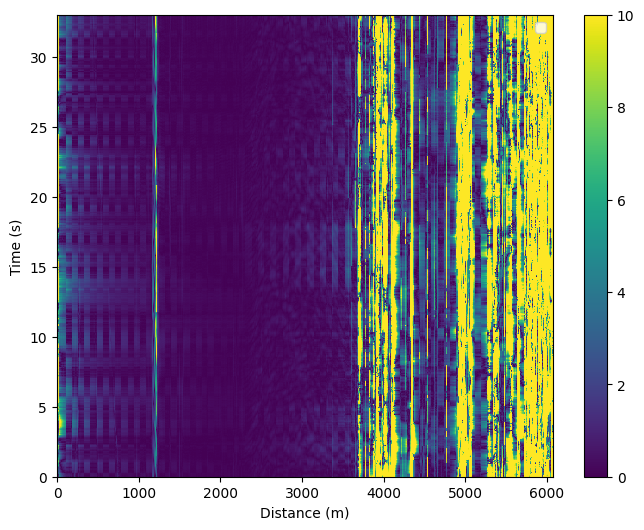

In [9]:
# cut down for plotting 
ds = 1 # Downsampling step
#xmin = 1e4
# xmax = 5e4
# idx = np.logical_and(x>=xmin,x<=xmax)

fig,ax = plt.subplots(1,1,figsize=(8,6))
im = ax.pcolormesh(x[:],t[::ds],np.abs(signal.hilbert(data[::ds,:])),cmap='viridis',vmin = 0,vmax = 1e1)
#ax.plot(x[idx],(x[idx]-xmin)/1500,'k--',linewidth=2,label='1500 m/s')
ax.legend(loc='upper right')
#ax.set_xlim([xmin,xmax])
#ax.set_ylim([min(t),max(t)])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Distance (m)')
fig.colorbar(im,ax=ax)

In [10]:
f = fftshift(fftfreq(ns*N, d = 1/fs))
k = fftshift(fftfreq(int(len(x)), d = dx))

data_fft2 = np.abs(fftshift(fft2(detrend(data),workers = 4)))

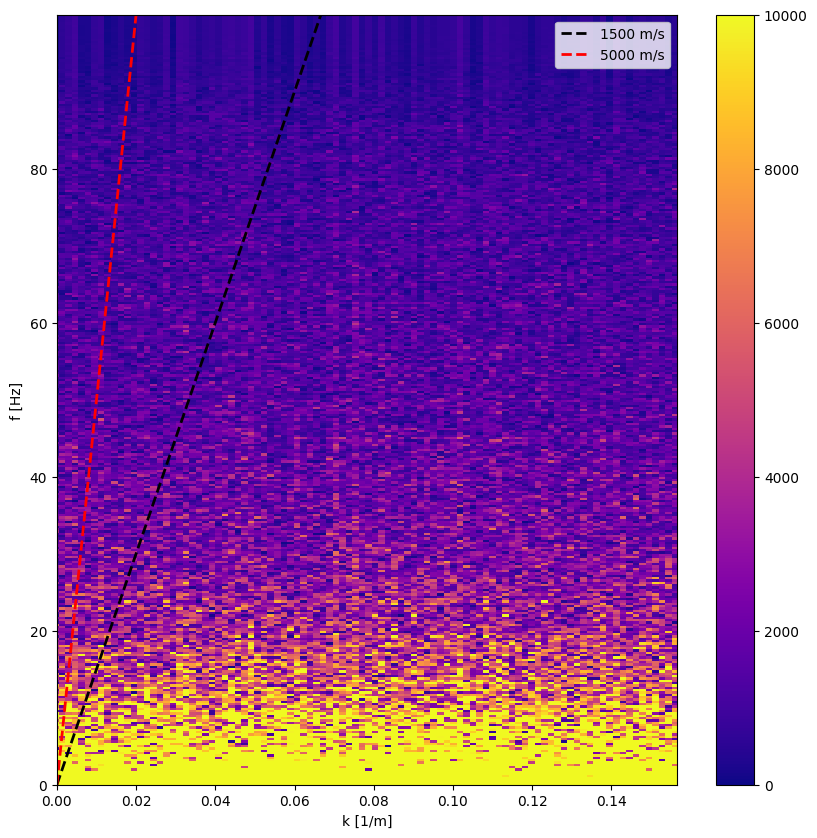

In [11]:
ds = 10
fig,ax=plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('w')
im = plt.pcolormesh(k[::ds],f[::ds],data_fft2[::ds,::ds],cmap='plasma',vmin = 0, vmax = 1e4)
plt.plot(f/1500,f,'k--',linewidth=2,label=str(1500)+' m/s')
plt.plot(f/5000,f,'r--',linewidth=2,label=str(5000)+' m/s')

#plt.plot(f_num_n,f_num_n/c_max_n,'k-.',linewidth=2,label=str(c_max_n)+' m/s')
plt.xlim(0,k[-1])
plt.ylim(0,f[-1])
#plt.xlim(0,0.05)
#plt.ylim(-0.1,0.1)
plt.ylabel('f [Hz]')
plt.xlabel('k [1/m]')
plt.legend()
fig.colorbar(im,ax=ax)
plt.rcParams.update({'font.size': 18})
#plt.savefig('fk_ship.jpeg')

In [12]:
fmin = 5
fmax = fs/2-5
b,a = butter(4,[fmin,fmax],fs=fs,btype='bandpass')

#data *= np.tile(tukey(ns*N,alpha=0.1),(nx,1)).T
data_bp = filtfilt(b,a,data,axis=0)


/tmp/ipykernel_31702/1321960737.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


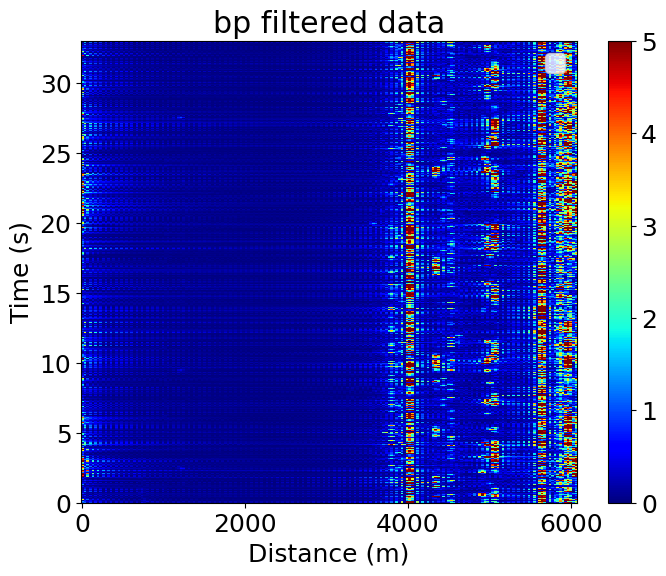

In [13]:
# cut down for plotting 
ds = 10
# xmin = 1e4
# xmax = 5e4
# idx = np.logical_and(x>=xmin,x<=xmax)

fig,ax = plt.subplots(1,1,figsize=(8,6))
im = ax.pcolormesh(x[::ds],t[:],np.abs(signal.hilbert(data_bp[:,::ds])),cmap='jet',vmin = 0, vmax = 5e0)
#ax.plot(x[:],(x[:]-xmin)/1500,'k--',linewidth=2,label='1500 m/s')
ax.legend(loc='upper right')
ax.set_title('bp filtered data')
#ax.set_xlim([xmin,xmax])
#ax.set_ylim([min(t),max(t)])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Distance (m)')
fig.colorbar(im,ax=ax)

In [14]:
c_min = 1400
c_max = 5000

xint = 1
f_num,k_num,g,ftr_bp_fk,tr_bp_fk = fk_filt(data_bp,1,fs,xint,dx,c_min,c_max)

#freq = np.fft.rfftfreq(ns,d = tint_n/fs_n) # frequency in Hz

/tmp/ipykernel_31702/536632187.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


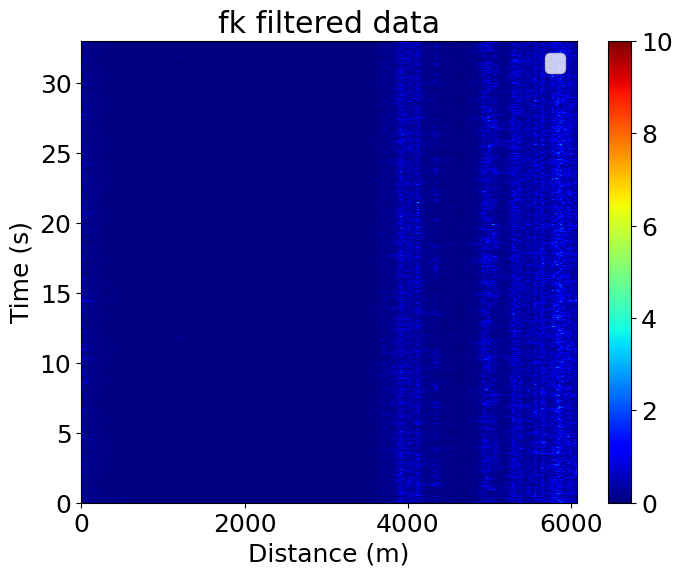

In [15]:
# cut down for plotting 
ds = 10
fig,ax = plt.subplots(1,1,figsize=(8,6))
im = ax.pcolormesh(x[:],t[:],np.abs(signal.hilbert(np.real(tr_bp_fk[:,:]))),cmap='jet',vmin = 0, vmax = 1e1)
#ax.plot(x[:],(x[:]-xmin)/1500,'k--',linewidth=2,label='1500 m/s')
ax.legend(loc='upper right')
ax.set_title('fk filtered data')
#ax.set_xlim([4300,4400])
#ax.set_ylim([min(t),max(t)])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Distance (m)')
fig.colorbar(im,ax=ax)

Text(0.5, 0, 'Time (s)')

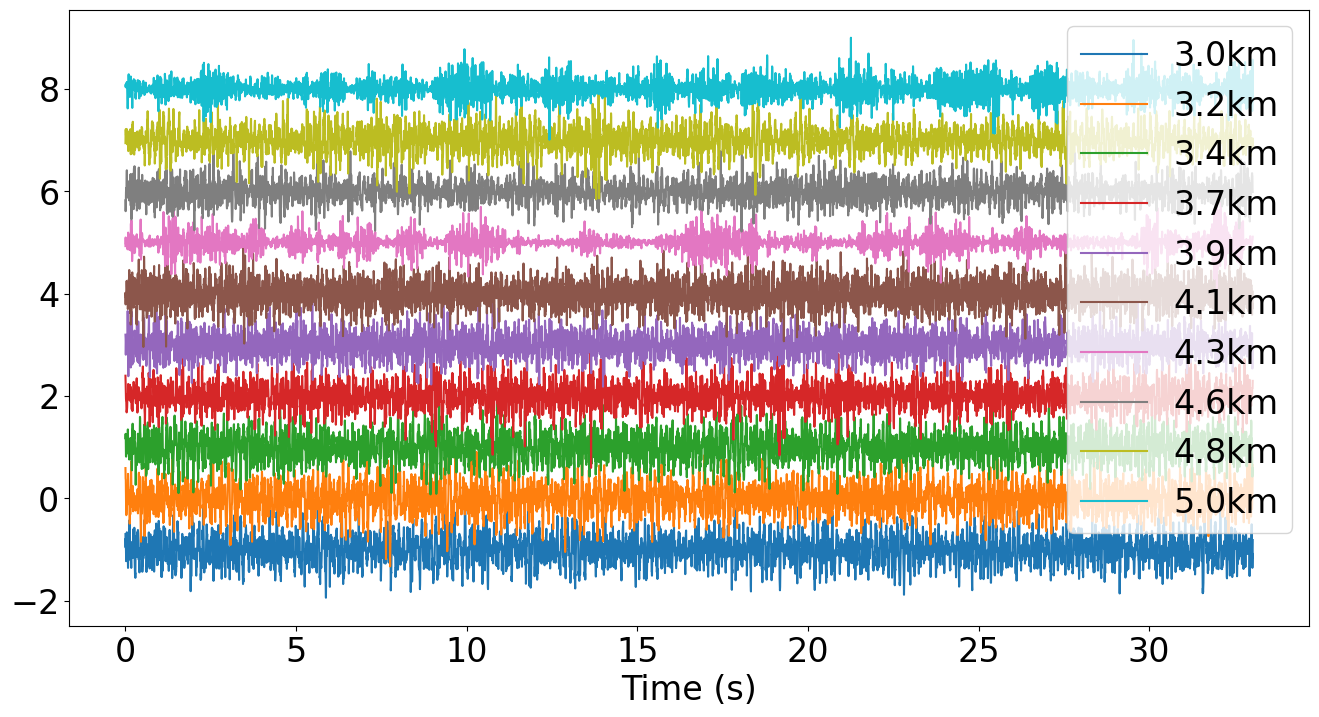

In [22]:
# cut down for plotting 
ds = 1
#xmin = 1e4
# xmax = 5e4
# idx = np.logical_and(x>=xmin,x<=xmax)

fig,ax = plt.subplots(1,1,figsize=(16,8))
for idx, i in enumerate(np.linspace(int(3000/dx), int(5000/dx), 10)):
    i = int(i)
    plt.plot(t[::ds],tr_bp_fk[::ds,i]/np.max(tr_bp_fk[::ds,i]) + (idx-1),label = f"{i*dx/1000:.1f}"
 + 'km')
ax.legend(loc='upper right')
#ax.set_xlim([xmin,xmax])
#ax.set_ylim([min(t),max(t)])
ax.set_xlabel('Time (s)')
# ax.set_ylabel('Channel number')


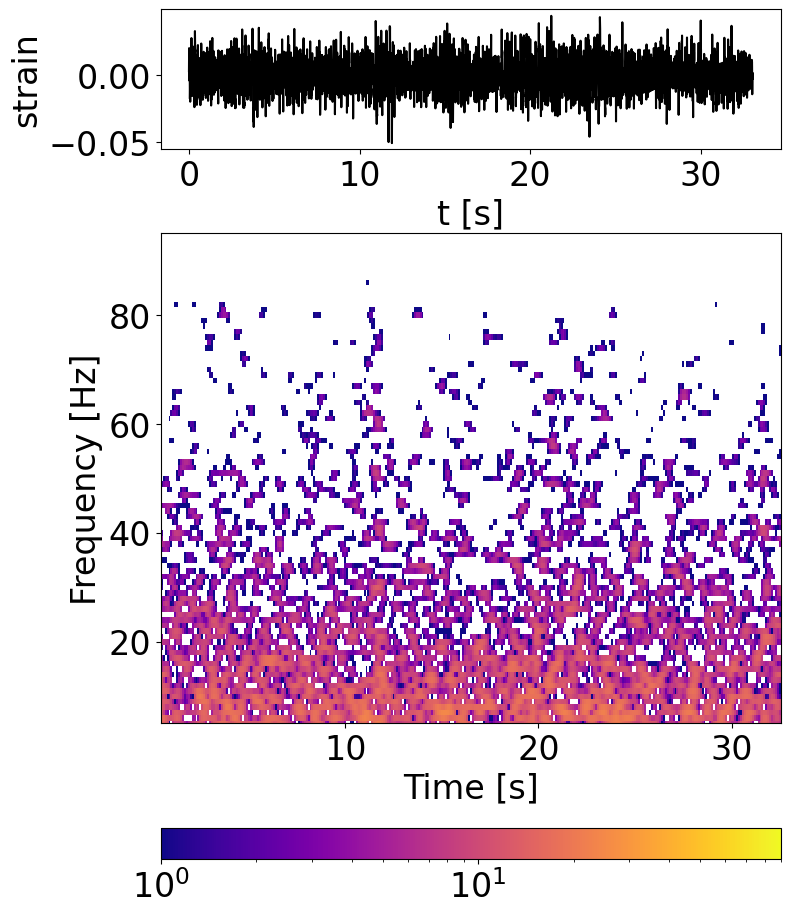

In [17]:
sel_ch_dist = 1000

fig, (ax1, ax2) = plt.subplots(2,figsize=(8,12),gridspec_kw={'height_ratios': [1, 5]})
plt.subplot(2,1,1)
plt.plot(t,np.real(tr_bp_fk[:,int((sel_ch_dist-xmin)/dx/xint)]),'k')
ax1.set_ylabel('strain',fontsize=24)
ax1.set_xlabel('t [s]',fontsize=24)
#ax1.set_xlim(0, 240)
# ax1.xaxis.set_major_formatter(date_format)
# ax1.xaxis_date()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.rcParams.update({'font.size': 24})

plt.subplot(2,1,2)
nperseg = 200
noverlap = int(0.9*nperseg)
nfft = 200

f_spec, t_spec, S_av = signal.spectrogram(np.real(tr_bp_fk[:,int((sel_ch_dist-xmin)/dx/xint)]), fs, nfft=nfft , 
                                          window = 'hann',nperseg = nperseg,noverlap = noverlap,scaling='density')
num_ch_av = 1
for i in range(num_ch_av):
    f_spec, t_spec, Sxx = signal.spectrogram(np.real(tr_bp_fk[:,int((sel_ch_dist-xmin)/dx/xint+i)]), fs, nfft=nfft , window = 'hann',nperseg = nperseg,noverlap = noverlap,scaling='density')
    S_av = Sxx + S_av
S_av = S_av/num_ch_av

plt.pcolormesh(t_spec, f_spec, 10*np.log10(S_av/1e-6),cmap='plasma',norm=LogNorm(vmin = 1, vmax = 90))
plt.ylim(fmin,fmax)
#plt.xlim(75,100)
#plt.axis(xmin=2,xmax=238,ymin = 2,ymax = 30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Frequency [Hz]',fontsize=24)
plt.xlabel('Time [s]',fontsize=24)
plt.colorbar(orientation='horizontal')
#plt.show()
plt.rcParams.update({'font.size': 24})
#plt.savefig('high_freq_call_ds1.jpeg',dpi=300, bbox_inches='tight')